## Fine-tuning KOSMOS2.5 on Grounded OCR

Kosmos2.5 is a new vision language model in transformers, released by Microsoft. It can not only do OCR but it's also layout aware: it can detect parts of documents where it reads the text. This makes the model very robust. In this notebook, we will fine-tune [KOSMOS2.5](https://huggingface.co/microsoft/kosmos-2.5) on test split of [DocLayNet dataset](https://huggingface.co/datasets/merve/doclaynet-small). You can try out-of-the-box capabilities of KOSMOS2.5 [in this demo](https://huggingface.co/spaces/nielsr/kosmos-2.5-demo).

Let's get started by checking the dataset and splitting it for train and test. But first, install trackio for experiment tracking.

In [ ]:
!pip install -q trackio

In [6]:
from datasets import load_dataset

dataset = load_dataset("merve/doclaynet-small")['test']
dataset = dataset.train_test_split(test_size=0.1)
train_ds = dataset["train"]
test_ds = dataset["test"]

We're interested in two parts of this dataset:
- `image`: the documents
- `pdf_cells`: this contains bounding boxes and text inside the bounding box as a dict. It has more than one bounding box per image so it's a list of dictionaries.

Let's visualize the dataset, here's a generic function you can use to explore the dataset (it can have different lengths for pdf_cells so the util is a bit long).


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_cells(img, pdf_cells, min_side=1.0):
    W, H = img.size

    cells = []
    if pdf_cells and isinstance(pdf_cells[0], list):
        for group in pdf_cells:
          cells.extend(group)
    else:
        cells = pdf_cells or []

    def clip_xywh(x, y, w, h):
        x1, y1, x2, y2 = x, y, x + w, y + h
        if x2 <= 0 or y2 <= 0 or x1 >= W or y1 >= H:
            return None

        x1 = max(0.0, x1)
        y1 = max(0.0, y1)
        x2 = min(W, x2)
        y2 = min(H, y2)

        if x2 - x1 < min_side or y2 - y1 < min_side:
            return None
        return x1, y1, x2 - x1, y2 - y1

    fig, ax = plt.subplots(figsize=(10, 12))
    ax.imshow(img)
    ax.set_xlim(0, W)
    ax.set_ylim(H, 0)
    for cell in cells:
        x, y, w, h = cell["bbox"]
        clipped = clip_xywh(x, y, w, h)
        if clipped is None:
            continue
        cx, cy, cw, ch = clipped
        ax.add_patch(Rectangle((cx, cy), cw, ch, fill=False, linewidth=1.5))

        ax.text(cx + 10, cy + 20, cell["text"], fontsize=8, va="center_baseline", color="red")

    plt.tight_layout(); plt.show()
    plt.close(fig)

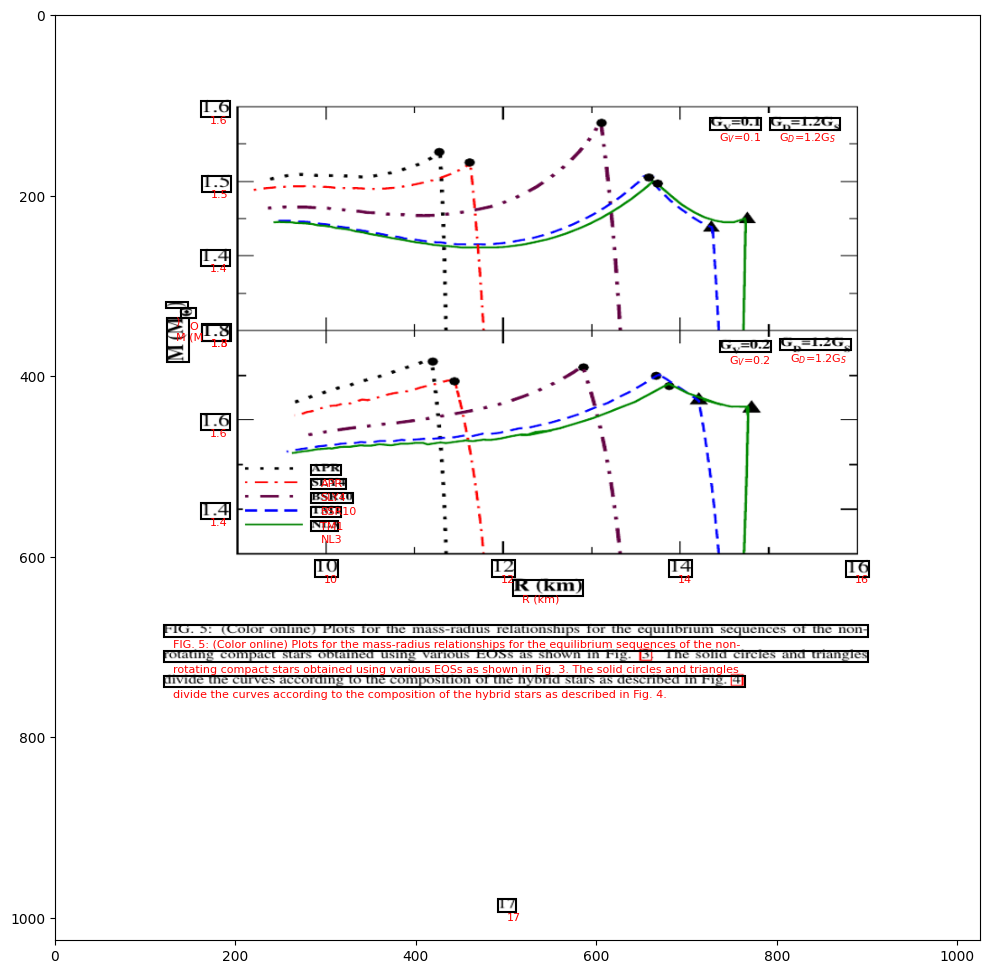

In [4]:
from PIL import Image
img = train_ds[30]["image"]
W, H = img.size

visualize_cells(img, train_ds[30]["pdf_cells"], min_side=1)

Let's load the model and the processor.

In [ ]:
from transformers import AutoProcessor, Kosmos2_5ForConditionalGeneration
import torch

model = Kosmos2_5ForConditionalGeneration.from_pretrained("microsoft/kosmos-2.5", device_map="cuda", dtype=torch.bfloat16)
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2.5")

The model outputs the bounding boxes and the text inside the following format, and to get the best of the model, we need to convert the dataset to this format as well:

`<bbox><x_206><y_28><x_384><y_46></bbox>This is the first text in this box\n<bbox><x_296><y_46><x_384><y_58></bbox>Second text but right under it\n<bbox>...`

Here's a batch preprocessing function to do this, and also to process the image width and height. This model expects the images to be divisible by the patch size. In this function, we calculate the bounding box coordinates by scaling this against the original size. Finally, we add the bounding box tokens with text and return it. We do this in batches.

In [6]:
import re
import torch

def preprocess_batch(pdf_cells_list, img_sizes, target_sizes):
    outputs = []
    for pdf_cells, img_size, target_size in zip(pdf_cells_list, img_sizes, target_sizes):
        img_w, img_h = img_size
        target_w, target_h = target_size

        # we need to flatten the metadata
        if not pdf_cells:
            cells = []
        elif isinstance(pdf_cells[0], list):
            cells = [cell for group in pdf_cells if group for cell in group]

        scale_x = target_w / float(img_w)
        scale_y = target_h / float(img_h)

        lines = []
        for cell in cells:
            if "bbox" not in cell:
                continue
            x, y, w, h = map(float, cell["bbox"])

            x0 = max(0.0, x)
            y0 = max(0.0, y)
            x1 = min(img_w, x + w)
            y1 = min(img_h, y + h)
            if (x1 - x0) < 1.0 or (y1 - y0) < 1.0:
                continue

            px0 = int(round((x0 * scale_x)))
            py0 = int(round((y0 * scale_y)))
            px1 = int(round((x1 * scale_x)))
            py1 = int(round((y1 * scale_y)))
            if not (px1 > px0 and py1 > py0):
                continue


            text = re.sub(r"\s+", " ", cell["text"].replace("\r", " ")).strip()
            text = text.replace("<", "‹").replace(">", "›")

            lines.append(f"<bbox><x_{px0}><y_{py0}><x_{px1}><y_{py1}></bbox>{text}")

        outputs.append("\n".join(lines))
    return outputs

Here we pass the image through processor once to get the height and width, these dimensions are what images are going to be resized per divisible patch size of the model.

The collate function batches images together, preprocesses the target output in model's own format, then passes them through processor. Puts the target tokens inside the batch. Lastly, we also need to set the input tokens to -100 to not include them in loss calculation (this is called prompt masking).

In [7]:
def collate_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]
    pdf_cells_list = [example["pdf_cells"] for example in examples]
    img_sizes = [img.size for img in images]

    target_sizes = []
    for img in images:
        inp = processor(images=img, return_tensors="pt")
        target_sizes.append((int(inp["width"]), int(inp["height"])))

    targets = preprocess_batch(pdf_cells_list, img_sizes, target_sizes)

    PROMPT = "<ocr>"
    full_texts = [PROMPT + t for t in targets]

    inputs = processor(text=full_texts, images=images, return_tensors="pt", padding=True, truncation=True)

    labels = inputs["input_ids"].clone()

    prompt_ids_batch = processor.tokenizer([PROMPT] * len(full_texts), add_special_tokens=True).input_ids

    # mask input part
    for idx, prompt_ids in enumerate(prompt_ids_batch):
        labels[idx, :len(prompt_ids)] = -100

    inputs["labels"] = labels
    return inputs


We can now setup the trainer.

In [8]:
from transformers import TrainingArguments
args=TrainingArguments(
            num_train_epochs=2,
            remove_unused_columns=False,
            per_device_train_batch_size=1,
            per_device_eval_batch_size=2,
            gradient_accumulation_steps=4,
            warmup_steps=2,
            learning_rate=2e-5,
            weight_decay=1e-6,
            adam_beta2=0.999,
            logging_steps=100,
            optim="adamw_torch",
            save_strategy="steps",
            save_steps=1000,
            save_total_limit=1,
            output_dir="kosmos2_5",
            bf16=True,
            report_to=["trackio"],
            dataloader_pin_memory=False,
            push_to_hub=True
        )

In [9]:
from transformers import Trainer

trainer = Trainer(
        model=model,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        data_collator=collate_fn,
        args=args
        )

Kick-off the training.

In [ ]:
trainer.train()


Let's put it to test.

In [ ]:
from transformers import AutoProcessor, Kosmos2_5ForConditionalGeneration
import torch

model = Kosmos2_5ForConditionalGeneration.from_pretrained("merve/kosmos-2.5-ft", device_map="cuda", dtype=torch.bfloat16)
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2.5")

In [16]:
import re

image = test_ds[0]["image"]
prompt = "<ocr>"
inputs = processor(text=prompt, images=image, return_tensors="pt")
height, width = inputs.pop("height"), inputs.pop("width")
raw_width, raw_height = image.size
scale_height = raw_height / height
scale_width = raw_width / width

inputs = {k: v.to("cuda") if v is not None else None for k, v in inputs.items()}
inputs["flattened_patches"] = inputs["flattened_patches"].to(torch.bfloat16)

Infer.

In [17]:
generated_ids = model.generate(
    **inputs,
    max_new_tokens=2000,
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

In [28]:
image = test_ds[0]["image"]

In [29]:
import re
from PIL import ImageDraw

def post_process(y, scale_height, scale_width):

    pattern = r"<bbox><x_\d+><y_\d+><x_\d+><y_\d+></bbox>"
    bboxes_raw = re.findall(pattern, y)
    lines = re.split(pattern, y)[1:]
    bboxes = [list(map(int, re.findall(r"\d+", bb))) for bb in bboxes_raw]

    out_lines = []
    for i, box in enumerate(bboxes):
        if len(box) != 4:
            continue
        x0, y0, x1, y1 = box

        if x0 >= x1 or y0 >= y1:
            continue

        sx0 = int(x0 * scale_width)
        sy0 = int(y0 * scale_height)
        sx1 = int(x1 * scale_width)
        sy1 = int(y1 * scale_height)

        label = lines[i] if i < len(lines) else ""
        label = label.lstrip(", ").strip()

        out_lines.append(f"{sx0},{sy0},{sx1},{sy0},{sx1},{sy1},{sx0},{sy1},{label}")

    return "\n".join(out_lines)


output_text = post_process(generated_text[0], scale_height, scale_width)
print(output_text)

draw = ImageDraw.Draw(image)

for line in output_text.strip().splitlines():
    coords = re.findall(r"-?\d+", line)[:8]
    if len(coords) < 8:
        continue
    xy = list(map(int, coords))
    draw.polygon(xy, outline="red")

image.save("output.png")


943,18,986,18,986,28,943,28,SMFG
674,21,895,21,895,29,674,29,Notes to Consolidated Financial Statements
119,100,318,100,318,112,119,112,26. Changes in Net Assets
133,117,150,117,150,127,133,127,(1)
160,117,551,117,551,127,160,127,Type and number of shares issued and treasury shares are as follows:
660,132,751,132,751,141,660,141,Number of shares
160,156,303,156,303,165,160,165,Year ended March 31, 2011
493,146,546,146,546,155,493,155,March 31,
506,156,533,156,533,165,506,165,2010
623,156,664,156,664,165,623,165,Increase
745,156,789,156,789,165,745,165,Decrease
865,146,917,146,917,155,865,155,March 31,
877,156,904,156,904,165,877,165,2011
160,170,235,170,235,180,160,180,Shares issued
174,185,454,185,454,195,174,195,Common stock...................................................
468,185,555,185,555,195,468,195,1,414,055,625
666,185,680,185,680,195,666,195,—
774,185,789,185,789,195,774,195,—
841,185,928,185,928,195,841,195,1,414,055,625
174,199,454,199,454,209,174,209,Preferred stock (1st

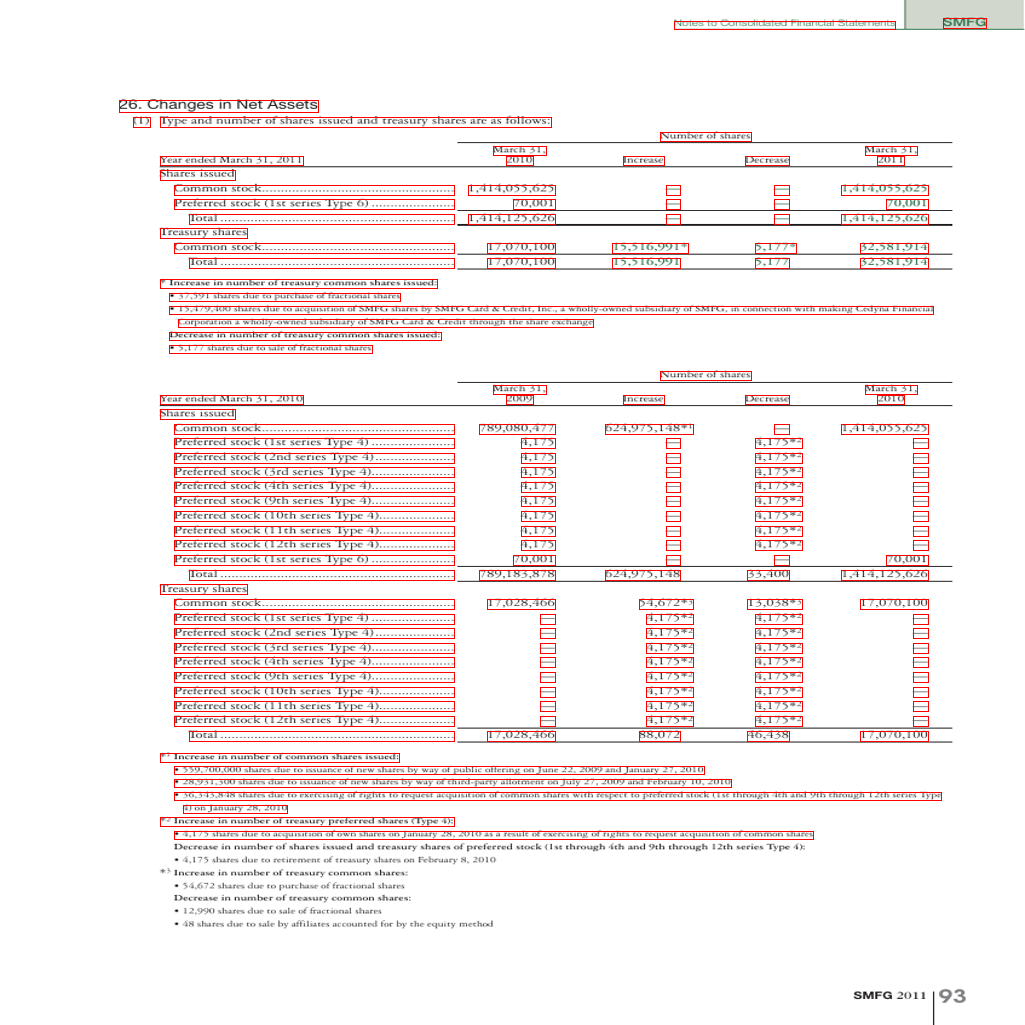

In [30]:
display(image)

Great!
To learn more about KOSMOS2.5, please see [this repository](https://huggingface.co/microsoft/kosmos-2.5). Also check-out [KOSMOS2.5-chat](https://huggingface.co/microsoft/kosmos-2.5-chat) for VQA tasks.

